## Core

- Measure fluxes from a region at multiple frequencies



In [2]:
import numpy as np
from astropy.io import ascii, fits
import fluxInt
import pbCorr
import synCl
from prettytable import PrettyTable


fint = fluxInt.flInt()

pb = pbCorr.pbcorr()
syn = synCl.synClean()

rootDir = '/home/maccagni/Projects/MFS/FornaxA/contData/Core/'
imDir = rootDir+'inIms/'

fint.rootdir = rootDir
syn.rootdir = rootDir
pb.rootdir = rootDir


tableName = rootDir+'coreFileNames.tbl'
tableFileNames= ascii.read(tableName,format='csv')

print tableFileNames.columns[0]

print '''\t+---------+\n\t Inputs loaded\n\t+---------+'''



    ERROR: Montage commands could not be found.

    In order to use the montage_wrapper module, you will first need to
    install the IPAC Montage software from:

        http://montage.ipac.caltech.edu

    and ensure that the Montage commands (e.g. mAdd, mProject, etc.) are in
    your $PATH. Your current $PATH variable contains the following paths,
    but none of them contain the Montage commands:

        PATH = /Users/maccagni/programs/anaconda2/bin:/usr/local/karma/cm_sc
           ript:/usr/local/karma/csh_script:/usr/local/karma/site/x86_64
           _Darwin/bin:/usr/local/karma/bin:/Users/maccagni/programs/rad
           iobs:/usr/local/Cellar/gcc/8.2.0/bin:/usr/local/opt/inetutils
           /libexec/gnubin:/Users/maccagni/programs/patchelf-0.9/bin:/Us
           ers/maccagni/programs/anaconda2/envs:/Users/maccagni/programs
           /anaconda2/bin:/Users/maccagni/programs/:/usr/local/bin:/usr/
           local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/
   

SystemExit: 1

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


We measure the flux in 6 frequency interval centred at: 

- 1.030 GHz (MeerKAT)
- 1.440 GHz (MeerKAT)
- 1.500 GHz (VLA)
- 4.800 GHz (VLA)
- 14.00 GHz (VLA)
- 108.0 GHz (ALMA)


We measure the flux in each map at its original spatial resolution. Since the images have very different fields of view, we draw a broad region in the centre that includes the core in all images. We measure as flux all signal above 3$\cdot$ r.m.s of the image.

The noise of the MeerKAT images (and VLA at 1500 MHz) is given in the input table, since it needs to be measured outside the extended radio lobes, that otherwise would be included in the measurement.


In [3]:
#-------------------------------------------------#
# Primary beam correction
#-------------------------------------------------#

fileNames=np.empty([len(tableFileNames.columns[0])],dtype='object')
for i in xrange(0,len(tableFileNames.columns[0])):

    fileName = rootDir+tableFileNames.columns[0][i]
    if fileName == '/home/maccagni/Projects/MFS/FornaxA/contData/core/inIms/Alma_115GHz.fits':
        fileNames[i] = fileName
        continue
    ff=fits.open(fileName)
    dats=ff[0].data
    heads=ff[0].header
    dats=np.squeeze(dats)
    
    if i <2:
        telescope= 'MeerKAT'
    elif i >2 and i< 5:
        telescope= 'VLA'
        
    fileNamePbCorr = pb.BeamCorrect(fileName,dats,heads,telescope)
    fileNames[i] = fileNamePbCorr
    
print fileNames
    
print '''\t+---------+\n\t Primary beam correction done\n\t+---------+'''
 

NameError: name 'tableFileNames' is not defined

In [3]:
region = imDir+'cReg.reg'
cutoff = tableFileNames.columns[2]
errFlux = 5.
print '\t Executing FileList+Region Combo' 

fr=[]
flIntArray=[]
flErrArray=[]

for i in xrange(0,len(tableFileNames.columns[0])):

    fileName = rootDir+tableFileNames.columns[0][i]
#for i in xrange(0,len(fileNames)):
    datas,heads = fint.openFile(fileName)
    datas=np.squeeze(datas)
    heads=fint.cleanHead(heads)
    maskedData, background, rms, pixels=fint.maskDatReg(datas,heads,region,cutoff[i])

    noiseInt = rms *np.sqrt(pixels)
    
    if 'Frequency' in tableFileNames.dtype.names:
        freq = float(tableFileNames.columns[1][i])*1e6
        fr.append(freq)
                
    fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux)
    flIntArray.append(fluxint)
    
    t,flErr = fint.writeTable(heads,fluxint,noiseInt,numPixBeam,freq,errFlux)
    flErrArray.append(flErr)

    
syn.writeSynageTable(fr,flIntArray,flErrArray,'Core')

print '''\t+---------+\n\t Fluxes measured\n\t+---------+'''
  

	 Executing FileList+Region Combo


/home/maccagni/programs/radiobs/fluxInt.py:135: RuntimeWarning: invalid value encountered in less
  index_cut = datas < self.cutoff


	+---------+
	 Fluxes measured
	+---------+


**Output tables**:

```
~/Projects/MFS/FornaxA/contData/core/integratedFluxes.tbl'
~/Projects/MFS/FornaxA/contData/core/synageFlCore.tbl'
```

**...Run synage to analyse the spectral energy distribution...**

```
~/programs/synage/SYNAGE
exec synageCore.script
```

**Output SYNAGE tables**:

```
CiCore_point1_fit.dat
CiOFFCore_point1_fit.dat
```


In [6]:
statsCI = syn.readCIStats(rootDir+'synOut/CoreCI.stats')
statsCIOFF =  syn.readCIOFFStats(rootDir+'synOut/CoreCIOFF.stats')

tot= ascii.read(rootDir+'CoreFluxes.tbl', fast_reader=False)

modCI = syn.readCIMod(rootDir+'synOut/CoreCI_point1_fit.dat')
modCIOFF = syn.readCIMod(rootDir+'synOut/CoreCIOFF_point1_fit.dat')

CI = PrettyTable(['CI', 'value'])
for key, val in statsCI.items():
    CI.add_row([key, val])
print CI


CIOFF = PrettyTable(['CIOFF', 'value'])
for key, val in statsCIOFF.items():
    CIOFF.add_row([key, val])
print CIOFF

print '''\t+---------+\n\t Synage results read\n\t+---------+'''


+--------------+-------------+
|      CI      |    value    |
+--------------+-------------+
| alpha_errsup |  0.04749648 |
|    break     |   249973.6  |
|    chisq     |  0.9405434  |
|    chired    |  0.3135145  |
|  break_inf   |  -218713.5  |
|    alpha     |  0.9304751  |
|     ndf      |     3.0     |
| alpha_errinf | -0.05386017 |
|     norm     |  0.00259165 |
|  break_sup   |   26.37568  |
+--------------+-------------+
+--------------+--------------+
|    CIOFF     |    value     |
+--------------+--------------+
|   t_errinf   |     -0.0     |
|    tratio    |    0.001     |
|   t_errsup   | 0.0004764591 |
|    break     |   250000.0   |
|    chisq     |  0.9406456   |
|    alpha     |  0.9302628   |
| alpha_errinf | -0.05277748  |
| alpha_errsup |  0.02631769  |
|    chired    |  0.4703228   |
|     ndf      |     2.0      |
|  break_inf   |  -229562.9   |
|  break_sup   |     0.0      |
|     norm     | 0.002593583  |
+--------------+--------------+
	+---------+
	 Synage 

In [7]:
#-------------------------------------------------#
# Plot SED
#-------------------------------------------------#
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
from matplotlib import transforms as mtransforms

def plot_CI_over_CIOFF(tot,mod_CI,mod_CIOFF,statsCI,statsCIOFF,labe,color_plot,sed):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'Frequency [MHz]')
    ax1.set_ylabel(r'Flux density [Jy]')
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    ax1.set_ylim([1e-3,2e2])
    ax1.set_xlim([10,5e5])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    print color_plot[0]


    
    # MODELS
    
    idx_max = (np.abs(mod_CI[0] - 5e5)).argmin()
    idx_min = (np.abs(mod_CI[0] - 30)).argmin()

    ax1.plot(mod_CI[0][idx_min:idx_max],mod_CI[1][idx_min:idx_max],lw=3, marker=' ', 
             color=color_plot[0], linestyle=':',label='CI',alpha=0.5)

    idx_br = (np.abs(mod_CI[0] - float(statsCI['break']))).argmin()
    ax1.axvline(statsCI['break'],ymin=0,ymax=0.58,ls=':',c=color_plot[0],lw=2,alpha=0.5)

    ax1.plot(mod_CIOFF[0][idx_min:idx_max],mod_CIOFF[1][idx_min:idx_max],lw=3, marker=' ', 
             color=color_plot[1], linestyle='--',label='CIOFF',alpha=0.5)

    idx_br = (np.abs(mod_CIOFF[0] - float(statsCIOFF['break']))).argmin()
    ax1.axvline(statsCIOFF['break'],ymin=0,ymax=0.55,ls='--',c=color_plot[1],lw=2,alpha=0.5)
    
    totplot = ax1.errorbar(tot['Frequency [MHz]'],tot['Integrated Flux [Jy]'], yerr=tot['Error [Jy]'],
             marker='o', color=color_plot[0], linestyle=' ',label=labe,capsize=6) 

    totplot[-1][0].set_linestyle('--')
    totplot[-1][0].set_linewidth(3)    
    #ax1.axvline(br_f_no217,ymin=0,ymax=0.73,ls='-.',c='cyan',lw=1) 

    legend = plt.legend(loc=1, prop={'size': 20})
    legend.get_frame().set_edgecolor('black')

    # Save figure to file
    #plt.savefig(sed,overwrite = True)


print '\n\t-----> Loaded <-----'


	-----> Loaded <-----


green


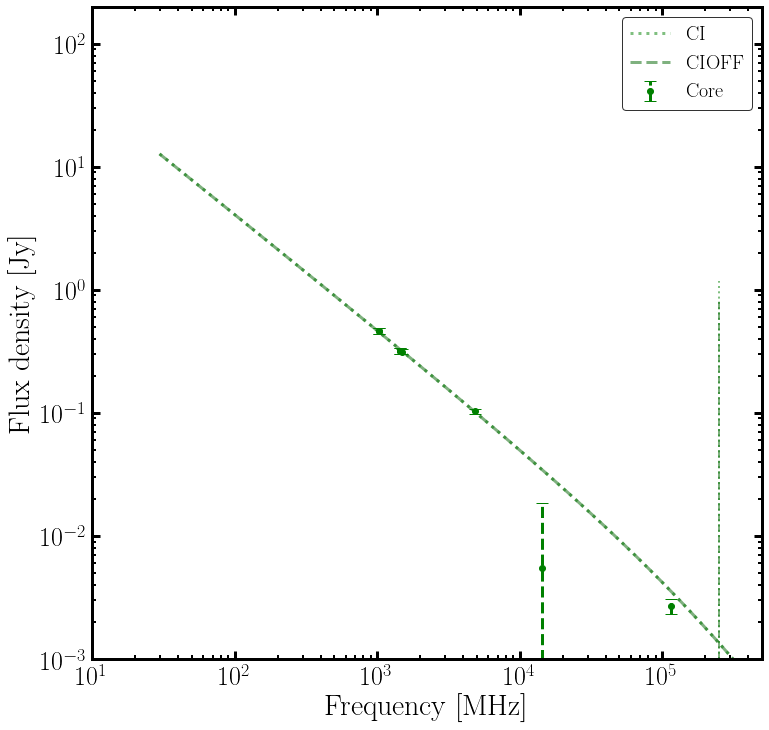

In [8]:
outplot=rootDir+'prova_core.png'
plot_CI_over_CIOFF(tot,modCI,modCIOFF,statsCI,statsCIOFF,'Core',['green','darkgreen','mediumseagreen'],outplot)